<a href="https://colab.research.google.com/github/devakar771/Sentiment-Analysis/blob/main/Sentiment_Analysis_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [ ]:
from matplotlib import style,rcParams
style.use('seaborn-white')
rcParams['figure.figsize'] = 10,5
import warnings
warnings.filterwarnings('ignore')

# DATA IMPORT AND PREPROCESSING

- Remove stop words
- Using WordNetLemmatizer convert different forms of words into a single item but still keeping the context intact

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

- Using CountVectorizer transform text to vectors
- GridSearchCV - for hyperparameter tuning

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#### Evaluation Metrics
1. Accuracy Score - no. of correctly classified instances/total no. of istances
2. Precision Score
3. Recall Score
4. Roc Curve
5. Classification Report
6. Confusion Matrix

In [ ]:
!pip install scikit-plot

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report
from scikitplot.metrics import plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

- Data is in text format, seperated by semi colons
- Create the data frame with read_csv() and parameters as "delimeter" and "names".

In [ ]:
df_train = pd.read_csv("/content/train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("/content/val.txt",delimiter=';',names=['text','label'])

In [ ]:
# not using validation set
df = pd.concat([df_train,df_val])

In [ ]:
print("Shape of the DataFrame:",df.shape)

Shape of the DataFrame: (18000, 2)


In [ ]:
df.reset_index(inplace=True,drop=True)

In [ ]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


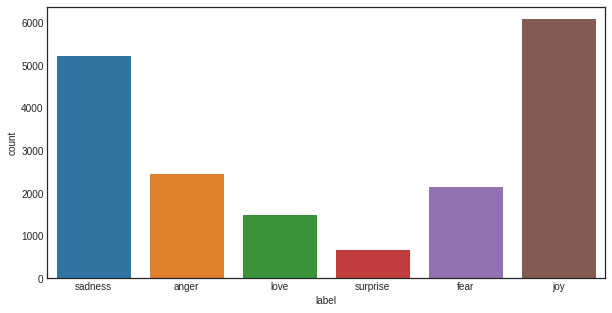

In [ ]:
sns.countplot(df.label)

#### Multi class classification
- "joy"
- "love"
- "surprise"
- "anger"
- "sadness"
- "fear"

#### Custom encoder to convert categorical target labels to numerical form.

In [ ]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =0, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value = 2, inplace=True)
    df.replace(to_replace ="fear", value =3, inplace=True)
    df.replace(to_replace ="anger", value =4, inplace=True)
    df.replace(to_replace ="sadness", value =5, inplace=True)

In [ ]:
custom_encoder(df['label'])

In [ ]:
df.head()

,text,label
0,i didnt feel humiliated,5
1,i can go from feeling so hopeless to so damned...,5
2,im grabbing a minute to post i feel greedy wrong,4
3,i am ever feeling nostalgic about the fireplac...,1
4,i am feeling grouchy,4


In [ ]:
#object of WordNetLemmatizer
lm = WordNetLemmatizer()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [ ]:
corpus = text_transformation(df['text'])

#### Now, we will create a Word Cloud. It is a data visualization technique used to depict text in such a way that, the more frequent words appear enlarged as compared to less frequent words.

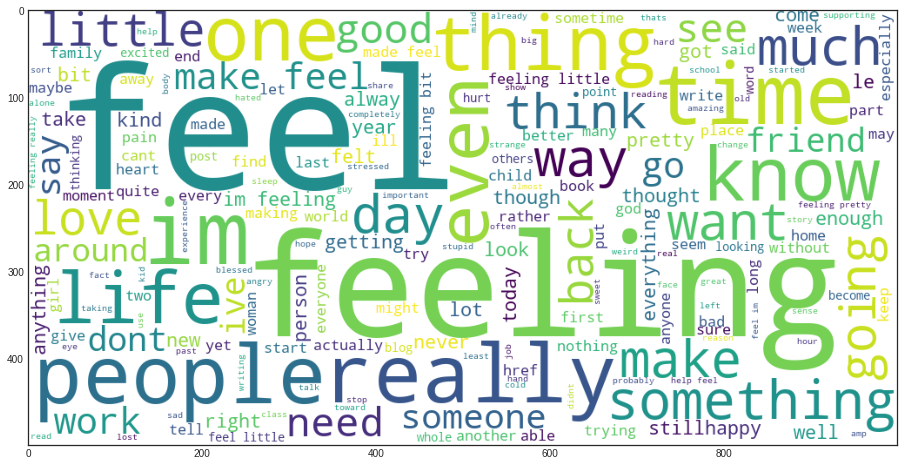

In [ ]:
rcParams['figure.figsize'] = 20,8
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)

wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

### Now, we will use Bag of Words Model(BOW)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)

In [ ]:
X = traindata
y = df.label

###  Models to be used: 
- MultinomialNB
- SVM 
- Random Forest Classifier

**Tune the hyperparameters using GridSearchCV**

In [ ]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [500, 1000],
             'max_depth': [10, None],
             'min_samples_split': [5],
             'min_samples_leaf': [1],
             'bootstrap': [True]}

In [ ]:
tuned_parameters = {
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [ ]:
SVC_params = {'tfidf__use_idf': (True, False),
              'tfidf__norm': ('l1', 'l2'),
              'svc__C': [0.01, 0.1, 1],
              }

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}

In [ ]:
text_clf = Pipeline([('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
clf = GridSearchCV(text_clf, tuned_parameters, cv=10, return_train_score=True, n_jobs=-1)
clf.fit(X, y)
clf.best_params_

{'clf__alpha': 0.1, 'tfidf__norm': 'l2', 'tfidf__use_idf': True}

In [ ]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

pipeline_svm = Pipeline([('tfidf', TfidfTransformer()), 
                            ('svc', SVC(probability=True, kernel="linear", class_weight="balanced", decision_function_shape='ovo'))])

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = SVC_params, 
                    cv = kfolds,
                    verbose=1,   
                    n_jobs=-1) 
grid_svm.fit(X, y)
grid_svm.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 154.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 196.9min finished


{'svc__C': 1, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}

#### Displays models and their respective parameters, mean test score and rank. 

In [ ]:
for i in range(6):
    print('Parameters: ',grid_search.cv_results_['params'][i])
    print('Mean Test Score: ',grid_search.cv_results_['mean_test_score'][i])
    print('Rank: ',grid_search.cv_results_['rank_test_score'][i])

Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.5451666666666666
Rank:  6
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Mean Test Score:  0.5448333333333333
Rank:  7
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.5455555555555556
Rank:  5
Parameters:  {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}
Mean Test Score:  0.5446666666666666
Rank:  8
Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Mean Test Score:  0.9570555555555555
Rank:  1
Parameters:  {'bootstrap': True, 'max_depth': None, 'max

In [ ]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])

In [ ]:
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Test Data Transformation
#### Read the test data and perform the same transformations done on training data and finally evaluate the model on it's predictions.

In [ ]:
test_df = pd.read_csv('/content/test.txt',delimiter=';',names=['text','label'])

In [ ]:
X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)

In [ ]:
#predict the target NB
predictionsNB = clf.predict(testdata)

In [ ]:
#predict the target RF
predictions = rfc.predict(testdata)

In [ ]:
#predict the target SVM
predictionsSVM = grid_svm.predict(testdata)

### Model Evaluation Metrics

Accuracy_score:  0.7705
Precision_score:  0.7705
Recall_score:  0.7705
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.11      0.19        66
           1       0.88      0.27      0.41       159
           2       0.73      0.96      0.83       695
           3       0.86      0.59      0.70       224
           4       0.91      0.57      0.70       275
           5       0.76      0.92      0.84       581

    accuracy                           0.77      2000
   macro avg       0.84      0.57      0.61      2000
weighted avg       0.80      0.77      0.74      2000



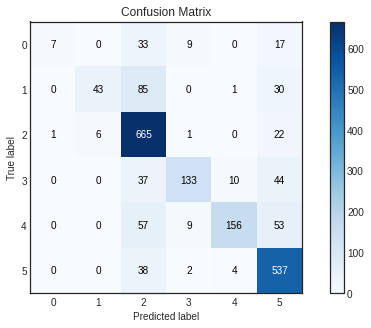

In [ ]:
# NB
rcParams['figure.figsize'] = 10,5
plot_confusion_matrix(y_test,predictionsNB)
acc_score = accuracy_score(y_test,predictionsNB)
pre_score = precision_score(y_test,predictionsNB,
                            pos_label='positive',
                            average='micro')
rec_score = recall_score(y_test,predictionsNB,
                         pos_label='positive',
                         average='micro')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print('-------------------------------------------------------------------')
cr = classification_report(y_test,predictionsNB)
print(cr)

Accuracy_score:  0.891
Precision_score:  0.7705
Recall_score:  0.7705
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.60      0.89      0.72        66
           1       0.69      0.94      0.80       159
           2       0.96      0.88      0.92       695
           3       0.89      0.83      0.86       224
           4       0.87      0.93      0.90       275
           5       0.96      0.89      0.93       581

    accuracy                           0.89      2000
   macro avg       0.83      0.90      0.85      2000
weighted avg       0.91      0.89      0.89      2000



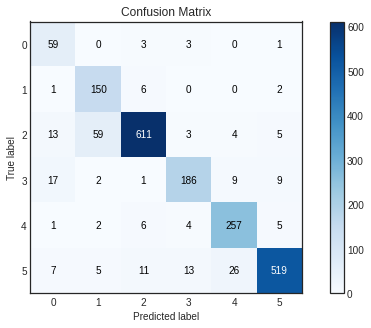

In [ ]:
# SVM
rcParams['figure.figsize'] = 10,5
plot_confusion_matrix(y_test,predictionsSVM)
acc_score = accuracy_score(y_test,predictionsSVM)
pre_score = precision_score(y_test,predictionsNB,
                            pos_label='positive',
                            average='micro')
rec_score = recall_score(y_test,predictionsNB,
                         pos_label='positive',
                         average='micro')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print('-------------------------------------------------------------------')
cr = classification_report(y_test,predictionsSVM)
print(cr)

Accuracy_score:  0.9015
Precision_score:  0.7705
Recall_score:  0.7705
-------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.61      0.68        66
           1       0.81      0.68      0.74       159
           2       0.89      0.94      0.92       695
           3       0.92      0.87      0.89       224
           4       0.90      0.92      0.91       275
           5       0.94      0.95      0.94       581

    accuracy                           0.90      2000
   macro avg       0.87      0.83      0.85      2000
weighted avg       0.90      0.90      0.90      2000



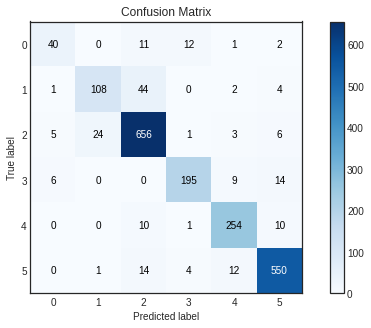

In [ ]:
# RF
rcParams['figure.figsize'] = 10,5
plot_confusion_matrix(y_test,predictions)
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictionsNB,
                            pos_label='positive',
                            average='micro')
rec_score = recall_score(y_test,predictionsNB,
                         pos_label='positive',
                         average='micro')
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print('-------------------------------------------------------------------')
cr = classification_report(y_test,predictions)
print(cr)

In [ ]:
predictions_probabilityNB = clf.predict_proba(testdata)

In [ ]:
predictions_probability = rfc.predict_proba(testdata)

In [ ]:
predictions_probabilitySVM = grid_svm.predict_proba(testdata)

In [ ]:
# NB
fpr,tpr,thresholds = roc_curve(y_test,predictions_probabilityNB[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

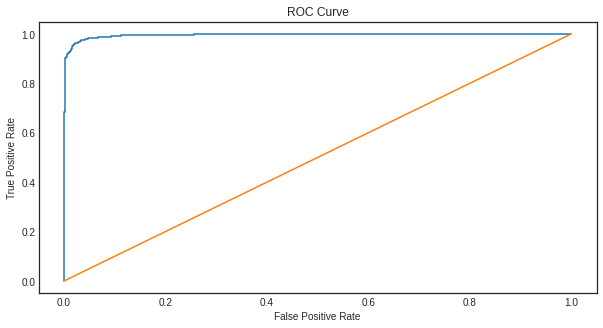

In [ ]:
# SVM
fpr,tpr,thresholds = roc_curve(y_test,predictions_probabilitySVM[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
# RF
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Predict for Custom Input

In [ ]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Surprise Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Love Sentiment.")
    elif prediction_input == 2:
        print("Input statement has Joy Sentiment.")
    elif prediction_input == 3:
        print("Input statement has Fear Sentiment.")
    elif prediction_input == 4:
        print("Input statement has Anger Sentiment.")
    elif prediction_input == 5:
        print("Input statement has Sadness Sentiment.")
    else:
        print("Invalid Statement.")

In [ ]:
def sentiment_predictor(input,func):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = func.predict(transformed_input)
    expression_check(prediction)

In [ ]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]
sentiment_predictor(input1,rfc)
sentiment_predictor(input2,rfc)

Input statement has Anger Sentiment.
Input statement has Joy Sentiment.


In [ ]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]
sentiment_predictor(input1,clf)
sentiment_predictor(input2,clf)

Input statement has Anger Sentiment.
Input statement has Joy Sentiment.


In [ ]:
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]
sentiment_predictor(input1,clf)
sentiment_predictor(input2,grid_svm)

Input statement has Anger Sentiment.
Input statement has Joy Sentiment.
